### Importerer nødvendige bibliotek

In [158]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm

import re

### Importerer og renser dataene

In [159]:
df = pd.read_csv("lego_data/Data/lego.population.csv", sep = ",", encoding = "latin1")

# fjerner forklaringsvariabler vi ikke trenger
df2 = df[['Set_Name', 'Theme', 'Pieces', 'Price', 'Pages',  'Unique_Pieces']]

# fjerner observasjoner med manglende datapunkter
df2 = df2.dropna()

# gjør themes om til string og fjern alle tegn vi ikke vil ha med
df2['Theme'] = df2['Theme'].astype(str)
df2['Theme'] = df2['Theme'].str.replace(r'[^a-zA-Z0-9\s-]', '', regex = True)

# fjerner dollartegn og trademark-tegn fra datasettet
df2['Price'] = df2['Price'].str.replace('\$', '', regex = True)

# og gjør så prisen om til float
df2['Price'] = df2['Price'].astype(float)

# det er dataset dere skal bruke!
df2

# skriv dette til en ny csv-fil
df2.to_csv("lego_data/Data/lego_cleaned.csv", index = False)


### Kategoriserer dataene etter den nye kategoriske variabelen

In [160]:
df = pd.read_csv("lego_data/Data/lego_cleaned.csv", sep = ",", encoding = "latin1")

# Liste med nøkkelord for transport og bygninger, generert av ChatGPT
transport_keywords = [
	'car', 'truck', 'bus', 'train', 'plane', 'helicopter', 'boat', 'ship', 'submarine', 'bike', 'motorcycle', 
	'scooter', 'ambulance', 'fire truck', 'police car', 'taxi', 'tractor', 'bulldozer', 'crane', 'forklift', 
	'spaceship', 'rocket', 'hovercraft', 'jet', 'yacht', 'canoe', 'kayak', 'glider', 'tanker', 'ferry', 
	'limousine', 'van', 'pickup', 'wagon', 'cart', 'gondola', 'shuttle', 'trolley', 'cab', 'sedan', 'coupe', 
	'convertible', 'roadster', 'minivan', 'suv', 'rv', 'camper', 'trailer', 'snowmobile', 'atv', 'golf cart', 
	'skateboard', 'rollerblades', 'hoverboard', 'segway', 'unicycle', 'monorail', 'zeppelin', 'blimp', 'dirigible', 
	'drone', 'uav', 'quad bike', 'dirt bike', 'speedboat', 'dinghy', 'lifeboat', 'rescue boat', 'patrol boat', 
	'fishing boat', 'sailboat', 'catamaran', 'trimaran', 'hydrofoil', 'jet ski', 'water scooter', 'snowcat', 
	'snowplow', 'snow groomer', 'icebreaker', 'hovercraft', 'amphibious vehicle', 'submersible', 'diving bell', 
	'bathyscaphe', 'rov', 'auv', 'glider', 'hang glider', 'paraglider', 'paramotor', 'microlight', 'ultralight',
	'lamborghini', 'porsche', 'ferrari', 'mobile', 'microfighter', 'rc', 'remote control', 'speeder', 'buggy',
	'kart', 'racer', 'racing', 'dragster', 'hot rod', 'chopper', 'harley', 'motorbike', 'motorbike', 'motorbike',
	'mclaren', 'bugatti','audi', 'bmw', 'mercedes', 'volkswagen', 'ford', 'starfighter', 'fighter', 'bomber',
	'interceptor', 'airliner', 'aircraft', 'airplane', 'jetliner', 'biplane', 'seaplane', 'helicopter', 'chopper',
	'cargo plane', 'fighter jet', 'bomber jet', 'stealth jet', 'spacecraft', 'rocket', 'dropship', 
	'chevrolet', 'cadillac', 'buick', 'dodge', 'chrysler', 'jeep', 'ram', 'tesla', 'nissan', 'toyota', 'honda',
	'aat', 'at-at', 'at-st', 'snowspeeder', 'speeder bike', 'podracer', 'landspeeder', 'starship', 'destroyer',
	'wing', 'at-ap', 'transport', 'aston', 'locomotive', 'apollo', 'fiat', 'at', 'bikes', 'walker', 'slave', 'gunship',
	'millennium', 'craft', 'tantive', 'sandcrawler', 'tank', 'sandspeeder', 'rover', 'volvo'
]

building_keywords = [
	'house', 'home', 'apartment', 'condo', 'mansion', 'villa', 'cottage', 'bungalow', 'chalet', 'castle', 'fortress', 
	'palace', 'tower', 'skyscraper', 'office', 'building', 'hospital', 'school', 'university', 'college', 'library', 
	'museum', 'church', 'cathedral', 'temple', 'mosque', 'synagogue', 'shrine', 'monastery', 'abbey', 'convent', 
	'chapel', 'basilica', 'pagoda', 'stupa', 'pyramid', 'ziggurat', 'lighthouse', 'windmill', 'barn', 'stable', 
	'shed', 'garage', 'warehouse', 'factory', 'plant', 'mill', 'workshop', 'studio', 'lab', 'laboratory', 'clinic', 
	'pharmacy', 'store', 'shop', 'market', 'mall', 'plaza', 'center', 'stadium', 'arena', 'gym', 'gymnasium', 
	'theater', 'cinema', 'auditorium', 'hall', 'court', 'station', 'terminal', 'depot', 'port', 'harbor', 'dock', 
	'pier', 'wharf', 'jetty', 'marina', 'boathouse', 'boatyard', 'shipyard', 'dry dock', 'slipway', 'quay', 'quayside',
	'resort', 'hq', 'supermarket', 'trafford', 'diner', 'turbine', 'bookshop', 'bookstore', 'library', 'hut', 'cabin',
	'cantina', 'bakery', 'restaurant', 'bistro', 'bar', 'pub'
]

# Function to categorize build type
def categorize_build_type(set_name):
	words = re.split(r'[ -]', set_name.lower())
	
	for word in words:
		if word in transport_keywords: return "transport"
		if word in building_keywords: return "building"

	return "other"

# Apply the function to create the new column
df['build_type'] = df['Set_Name'].apply(categorize_build_type)

# if a theme is Technic, then it is a transport
df.loc[df['Theme'] == 'Technic', 'build_type'] = 'transport'

# Write the dataset to a new csv file
df.to_csv("lego_data/Data/lego_with_type.csv", index = False)

### Henter den ferdige dataen for videre analyse

In [161]:
df2 = pd.read_csv("lego_data/Data/lego_with_type.csv", sep = ",", encoding = "latin1")

### VIF analyse for grad av multikollinearitet:

In [162]:
selected_columns = ['Pages', 'Unique_Pieces', 'build_type']

# Create a new DataFrame with only the selected columns
filtered_data = df2[selected_columns]
data = pd.get_dummies(filtered_data, columns=['build_type'], drop_first=True).astype(int)

# Check for NaN values and drop if necessary
data = data.dropna()

# Check if data is empty after transformations
if data.empty:
    raise ValueError("Data is empty after encoding and cleaning. Check input data for issues.")
else:
    print("Data has shape:", data.shape)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['feature'] = data.columns
vif_data['VIF'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]

print(vif_data)

Data has shape: (922, 4)
                feature       VIF
0                 Pages  3.841646
1         Unique_Pieces  4.376450
2      build_type_other  1.549584
3  build_type_transport  1.410594


### Antall sett i hver kategori:

In [163]:
print(df2['build_type'].value_counts())

other        545
transport    271
building     106
Name: build_type, dtype: int64


### Plot av pris per antall brikker:

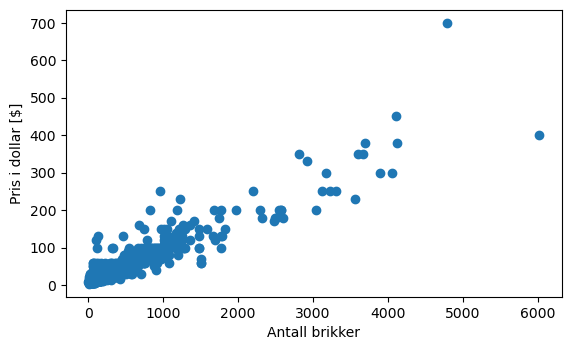

In [164]:
plt.scatter(df2['Pieces'], df2['Price'])
plt.xlabel('Antall brikker')
plt.ylabel('Pris i dollar [$]')
plt.gca().set_aspect(5)
plt.show()

### Pair plot

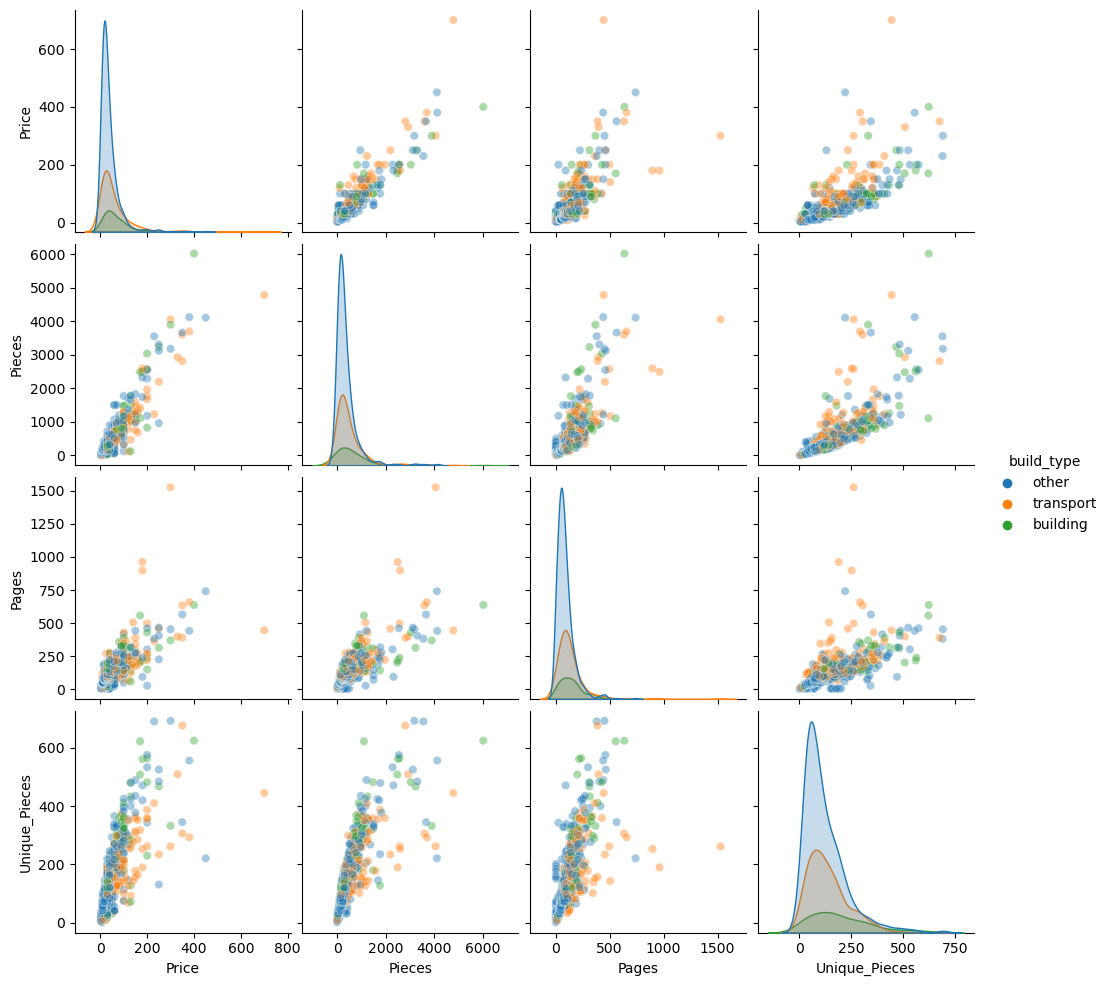

In [165]:
sns.pairplot(df2, vars = ['Price', 'Pieces', 'Pages', 'Unique_Pieces'],
             hue = 'build_type', 
             diag_kind = 'kde',
             plot_kws = dict(alpha = 0.4))
plt.show()

### Enkel lineær regresjon på pris og antall deler:

In [166]:
formel = 'Price ~ Pieces'

modell = smf.ols(formel, data = df2)
resultat = modell.fit()

resultat.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     5415.
Date:                Mon, 11 Nov 2024   Prob (F-statistic):               0.00
Time:                        16:58:44   Log-Likelihood:                -4161.6
No. Observations:                 922   AIC:                             8327.
Df Residuals:                     920   BIC:                             8337.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.8962      0.894      9.951      0.000       7.142      10.651
Pieces         0.0872      0.001     73.589      0.000       0.085       0.090
==============================================================================
Omnibus:                      736.003   Durbin-Watson:                   1.737
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            45431.936
Skew:                           3.115   Prob(JB):                         0.00
Kurtosis:                      36.820   Cond. No.                         927.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

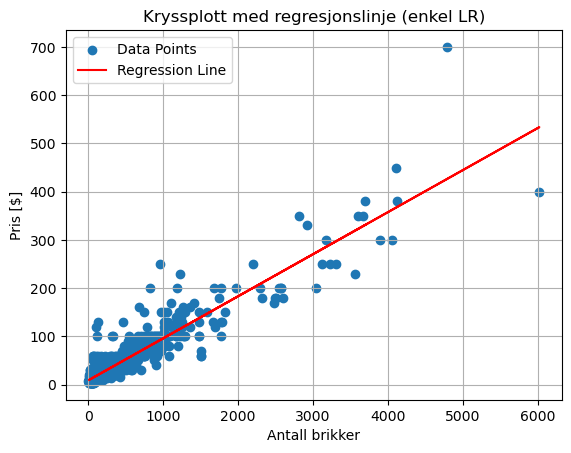

In [167]:
slope = resultat.params['Pieces']
intercept = resultat.params['Intercept']

regression_x = np.array(df2['Pieces'])

regression_y = slope * regression_x + intercept

plt.scatter(df2['Pieces'], df2['Price'], label='Data Points')
plt.plot(regression_x, regression_y, color='red', label='Regression Line')
plt.xlabel('Antall brikker')
plt.ylabel('Pris [$]')
plt.title('Kryssplott med regresjonslinje (enkel LR)')
plt.legend()
plt.grid()
plt.show()

### Enkel lineær regresjon på hver kategori:

In [168]:
# enkel LR for hvert tema hver for seg
mythemes = ['transport', 'building', 'other']
subset_df = df2[df2['build_type'].isin(mythemes)]
resultater = []
for i, theme in enumerate(mythemes):
    modell3 = smf.ols('Price ~ Pieces' , data = subset_df[subset_df['build_type'].isin([theme])])
    resultater.append(modell3.fit())

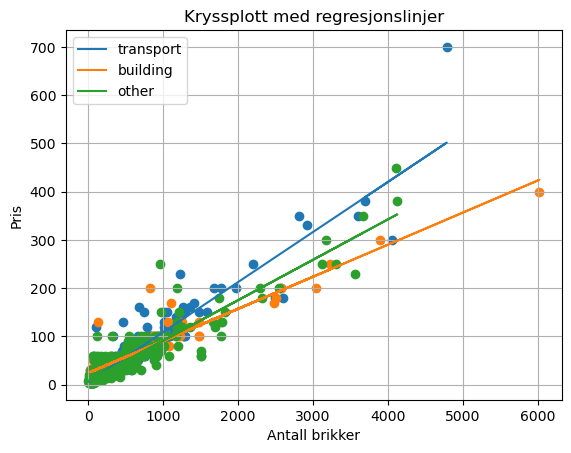

In [169]:
# plott av dataene og regresjonslinjene
for i, theme in enumerate(mythemes):
    slope = resultater[i].params['Pieces']
    intercept = resultater[i].params['Intercept']

    regression_x = np.array(subset_df[subset_df['build_type'].isin([theme])]['Pieces'])
    regression_y = slope * regression_x + intercept

    # Plot scatter plot and regression line
    plt.scatter(subset_df[subset_df['build_type'].isin([theme])]['Pieces'], subset_df[subset_df['build_type'].isin([theme])]['Price'], color=plt.cm.tab10(i))
    plt.plot(regression_x, regression_y, color=plt.cm.tab10(i), label=theme)
    
plt.xlabel('Antall brikker')
plt.ylabel('Pris')
plt.title('Kryssplott med regresjonslinjer')
plt.legend()
plt.grid()
plt.show()

## Multipell lineær regresjon:

In [170]:
# multippel lineær regresjon
modell3_mlr = smf.ols('Price ~ Pieces + Unique_Pieces + build_type' , data = subset_df)
modell3_mlr.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     1399.
Date:                Mon, 11 Nov 2024   Prob (F-statistic):               0.00
Time:                        16:58:45   Log-Likelihood:                -4147.5
No. Observations:                 922   AIC:                             8305.
Df Residuals:                     917   BIC:                             8329.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   7.8444      2.526      3.106      0.002       2.887      12.801
build_type[T.other]        -3.4561      2.368     -1.459      0.145      -8.104       1.192
build_type[T.transport]     4.0201      2.536      1.585      0.113      -0.957       8.997
Pieces                      0.0822      0.002     42.116      0.000       0.078       0.086
Unique_Pieces               0.0301      0.011      2.737      0.006       0.009       0.052
==============================================================================
Omnibus:                      796.005   Durbin-Watson:                   1.772
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            58512.229
Skew:                           3.480   Prob(JB):                         0.00
Kurtosis:                      41.401   Cond. No.                     4.30e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.3e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Evaluering:

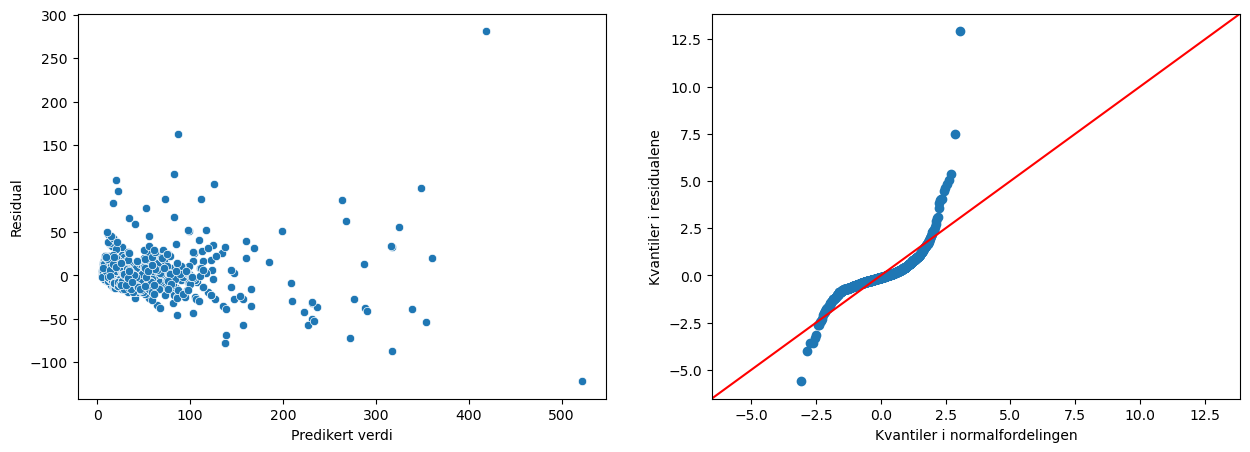

In [171]:
# Steg 5: Evaluere om modellen passer til dataene
# Plotte predikert verdi mot residual
figure, axis = plt.subplots(1, 2, figsize = (15, 5))
sns.scatterplot(x = modell3_mlr.fit().fittedvalues, y = modell3_mlr.fit().resid, ax = axis[0])
axis[0].set_ylabel("Residual")
axis[0].set_xlabel("Predikert verdi")

# Lage kvantil-kvantil-plott for residualene
sm.qqplot(modell3_mlr.fit().resid, line = '45', fit = True, ax = axis[1])
axis[1].set_ylabel("Kvantiler i residualene")
axis[1].set_xlabel("Kvantiler i normalfordelingen")
plt.show()